# Restaurant Revenue Prediction

## 1. Importing required packages and data

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler,
from sklearn.compose import ColumnTransformer
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
import warnings

In [7]:
df = pd.read_csv('data/Restaurant_revenue.csv')
df.head()

,Number_of_Customers,Menu_Price,Marketing_Spend,Cuisine_Type,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue
0,61,43.117635,12.663793,Japanese,36.236133,0,45,350.912040
1,24,40.020077,4.577892,Italian,17.952562,0,36,221.319091
2,81,41.981485,4.652911,Japanese,22.600420,1,91,326.529763
3,70,43.005307,4.416053,Italian,18.984098,1,59,348.190573
4,30,17.456199,3.475052,Italian,12.766143,1,30,185.009121


## 2. Data Preprocessing

In [8]:
df.isnull().sum()

Number_of_Customers          0
Menu_Price                   0
Marketing_Spend              0
Cuisine_Type                 0
Average_Customer_Spending    0
Promotions                   0
Reviews                      0
Monthly_Revenue              0
dtype: int64

In [9]:
df.duplicated().sum()

0

In [10]:
df.nunique()

Number_of_Customers            90
Menu_Price                   1000
Marketing_Spend              1000
Cuisine_Type                    4
Average_Customer_Spending    1000
Promotions                      2
Reviews                       100
Monthly_Revenue              1000
dtype: int64

In [11]:
df1 = df.copy()
df2 = df.copy()

In [12]:
dummies = pd.get_dummies(df1['Cuisine_Type'],drop_first=True).astype(int)
dummies

,Italian,Japanese,Mexican
0,0,1,0
1,1,0,0
2,0,1,0
3,1,0,0
4,1,0,0
...,...,...,...
995,0,1,0
996,0,0,1
997,0,1,0
998,0,1,0


In [13]:
df1 = pd.concat([df1,dummies], axis=1)
df1.head()

,Number_of_Customers,Menu_Price,Marketing_Spend,Cuisine_Type,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue,Italian,Japanese,Mexican
0,61,43.117635,12.663793,Japanese,36.236133,0,45,350.912040,0,1,0
1,24,40.020077,4.577892,Italian,17.952562,0,36,221.319091,1,0,0
2,81,41.981485,4.652911,Japanese,22.600420,1,91,326.529763,0,1,0
3,70,43.005307,4.416053,Italian,18.984098,1,59,348.190573,1,0,0
4,30,17.456199,3.475052,Italian,12.766143,1,30,185.009121,1,0,0


In [14]:
df1.drop('Cuisine_Type',axis=1,inplace=True)
df1.head()

,Number_of_Customers,Menu_Price,Marketing_Spend,Average_Customer_Spending,Promotions,Reviews,Monthly_Revenue,Italian,Japanese,Mexican
0,61,43.117635,12.663793,36.236133,0,45,350.912040,0,1,0
1,24,40.020077,4.577892,17.952562,0,36,221.319091,1,0,0
2,81,41.981485,4.652911,22.600420,1,91,326.529763,0,1,0
3,70,43.005307,4.416053,18.984098,1,59,348.190573,1,0,0
4,30,17.456199,3.475052,12.766143,1,30,185.009121,1,0,0


## 3. Model Training

In [15]:
X = df1.drop('Monthly_Revenue', axis = 1)
y = df1['Monthly_Revenue']

In [16]:
X.shape,y.shape

((1000, 9), (1000,))

In [17]:
ss = StandardScaler()

X_transformed = ss.fit_transform(X)
X_transformed

array([[ 0.29330145,  1.14418338,  0.46298522, ..., -0.54962108,
         1.67833069, -0.57735027],
       [-1.11078105,  0.86940951, -0.92095572, ...,  1.8194353 ,
        -0.59583014, -0.57735027],
       [ 1.05226497,  1.04339936, -0.90811591, ..., -0.54962108,
         1.67833069, -0.57735027],
       ...,
       [ 0.59688686, -1.16280727, -0.99557815, ..., -0.54962108,
         1.67833069, -0.57735027],
       [ 0.74867956,  0.66047401, -1.18305134, ..., -0.54962108,
         1.67833069, -0.57735027],
       [ 1.05226497,  0.39944108,  1.37443806, ...,  1.8194353 ,
        -0.59583014, -0.57735027]])

In [18]:
X_train,X_test,y_train,y_test = train_test_split(X_transformed,y,test_size=0.20,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((800, 9), (200, 9), (800,), (200,))

Creating an Evaluate Function to give all metrics after model Training

In [19]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [20]:
def model_trainer(X_train,X_test,y_train,y_test):
  models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(),
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()}
  model_list = []
  r2_list = []

  for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)


    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)


    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])

    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')

    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)

    print('='*35)
    print('\n')

  return model_list,r2_list


In [21]:
model_list,r2_list = model_trainer(X_train,X_test,y_train,y_test)

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 57.9967
- Mean Absolute Error: 46.4447
- R2 Score: 0.6869
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 59.6694
- Mean Absolute Error: 47.1919
- R2 Score: 0.6741


Lasso
Model performance for Training set
- Root Mean Squared Error: 58.0530
- Mean Absolute Error: 46.4773
- R2 Score: 0.6863
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 59.6881
- Mean Absolute Error: 47.0775
- R2 Score: 0.6739


Ridge
Model performance for Training set
- Root Mean Squared Error: 57.9968
- Mean Absolute Error: 46.4449
- R2 Score: 0.6869
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 59.6698
- Mean Absolute Error: 47.1884
- R2 Score: 0.6741


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 59.0849
- Mean Absolute Error: 46.8416
- R2 Score: 0.6751
---------

In [22]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
0,Linear Regression,0.674063
2,Ridge,0.674058
1,Lasso,0.673858
7,CatBoosting Regressor,0.630691
5,Random Forest Regressor,0.617099
8,AdaBoost Regressor,0.616704
3,K-Neighbors Regressor,0.576904
6,XGBRegressor,0.542783
4,Decision Tree,0.362874


In [23]:
lin_model = LinearRegression(fit_intercept=True)
lin_model = lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 67.41


### 4. Results

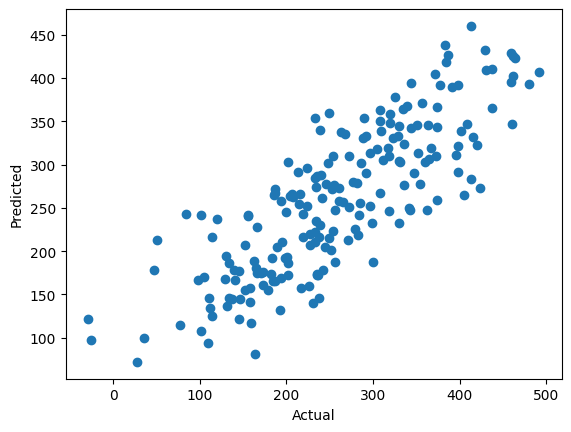

In [24]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

<Axes: xlabel='Monthly_Revenue'>

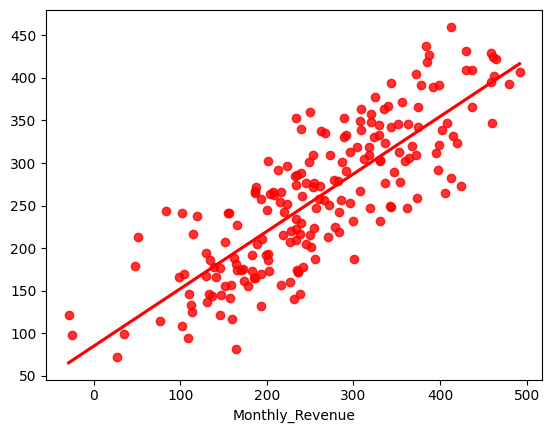

In [25]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red')

In [26]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
521,296.059897,252.654225,43.405672
737,233.602843,274.053379,-40.450536
740,317.786750,318.766096,-0.979346
660,398.272591,391.821422,6.451169
411,299.352893,232.510788,66.842105
...,...,...,...
408,325.068430,377.804086,-52.735657
332,286.278497,301.289203,-15.010706
208,384.770624,418.436407,-33.665783
613,323.304237,330.711388,-7.407151
